In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import galcheat
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pdf2image import convert_from_path

from madness_benchmark.utils import get_benchmark_config_path

mpl.rcParams["text.usetex"] = True
mpl.rcParams["savefig.dpi"] = 1200
# plt.rcParams[
#     "text.latex.preamble"
# ] = r"\usepackage{bm} \usepackage{amsmath}"  # for \text command

In [ ]:
with open(get_benchmark_config_path()) as f:
    benchmark_config = yaml.safe_load(f)
survey = galcheat.get_survey(benchmark_config["survey_name"])

In [ ]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)


def format_func(value, tick_number):
    # Format the y-axis labels as integers without decimals
    return "{:.3f}".format(value)

In [ ]:
density_level = "high"

data_path = os.path.join(
    benchmark_config["RESULTS_PATH"][benchmark_config["survey_name"]],
    density_level + "_density",
)
run_name = "kl2"  # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

isolated_plot_color = sns.color_palette("colorblind")[6]
blended_plot_color = sns.color_palette("colorblind")[1]

madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
scarlet_plot_ls = "-"

isolated_plot_ls = "dotted"
blended_plot_ls = "--"

scarlet_plot_label = r"\textsc{scarlet}"
madness_plot_label = r"\texttt{MADNESS}"
debvader_plot_label = r"\texttt{VAE-deblender}"

In [ ]:
madness_results = []
debvader_results = []
scarlet_results = []
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")
        )
    )
    debvader_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "debvader_results", str(file_num) + ".pkl")
        )
    )
    scarlet_results.append(
        pd.read_pickle(
            os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")
        )
    )

    actual_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")
        )
    )
    blended_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "blended_photometry", str(file_num) + ".pkl")
        )
    )

madness_results = pd.concat(madness_results)
debvader_results = pd.concat(debvader_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [ ]:
print("MADNESS average: " + str(np.mean(madness_results["r_cosd"])))
print("VAE-deblender average: " + str(np.mean(debvader_results["r_cosd"])))
print("scarlet average: " + str(np.mean(scarlet_results["r_cosd"])))

MADNESS average: 0.9918203802195275
VAE-deblender average: 0.9886957995041539
scarlet average: 0.9878187794101536


In [ ]:
print("MADNESS average: " + str(np.mean(madness_results["r_ssim"])))
print("VAE-deblender average: " + str(np.mean(debvader_results["r_ssim"])))
print("scarlet average: " + str(np.mean(scarlet_results["r_ssim"])))

MADNESS average: 0.9985344863407604
VAE-deblender average: 0.9979221963354837
scarlet average: 0.9980078562080519


In [ ]:
np.mean(debvader_results["r_cosd"])

0.9886957995041539

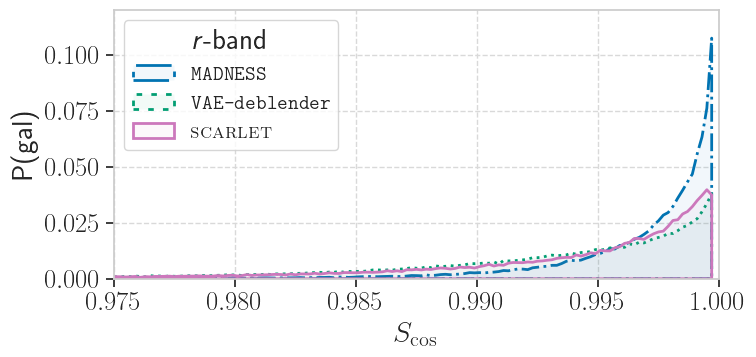

In [ ]:
bins = np.arange(0, 1, 0.0002)
text_cos = r"\text{cos}"
for mask_type in ["masked", "unmasked"]:
    for band_number, band in enumerate(survey.available_filters):
        plt.figure(figsize=(8, 4))
        sns.set(font_scale=1.75)
        sns.set_style("whitegrid", {"grid.color": ".85", "grid.linestyle": "--"})
        if mask_type == "masked":
            mask = (
                actual_photometry[band + "_phot_flux"].values
                / actual_photometry[band + "_phot_fluxerrs"].values
            ) > 5
        else:
            mask = np.ones(len(madness_results), dtype=bool)
        sns.histplot(
            madness_results[mask][band + "_cosd"].values,
            bins=bins,
            alpha=0.05,
            label=madness_plot_label,
            color=madness_plot_color,
            element="poly",
            stat="probability",
            ls=madness_plot_ls,
            lw=2,
        )
        sns.histplot(
            debvader_results[mask][band + "_cosd"].values,
            bins=bins,
            alpha=0.05,
            label=debvader_plot_label,
            color=debvader_plot_color,
            element="poly",
            stat="probability",
            ls=debvader_plot_ls,
            lw=2,
        )
        sns.histplot(
            scarlet_results[mask][band + "_cosd"].values,
            bins=bins,
            alpha=0.05,
            label=scarlet_plot_label,
            color=scarlet_plot_color,
            element="poly",
            stat="probability",
            ls=scarlet_plot_ls,
            lw=2,
        )

        # plt.legend(title= fr"\textit{{{band}}}-band", loc="upper left", fontsize=15)
        plt.legend(loc="upper left")

        ax = plt.gca()

        ax.xaxis.tick_bottom()
        ax.yaxis.tick_left()
        #     if band != "u":
        #         ax.get_legend().remove()
        plt.xlim([0.975, 1])
        plt.ylim([0, 0.12])
        plt.xlabel(r"$S_{\mathrm{cos}}$")
        plt.ylabel("P(gal)")

        plt.tight_layout()
        current_name_extension = "masked_" if mask_type == "masked" else ""
        # plt.savefig(result_dir_path + "/cosd_res_"+band)
        if band == "r":

            plt.legend(loc="upper left")

            current_name_extension = "masked_" if mask_type == "masked" else ""
            plt.savefig(
                os.path.join(
                    "results",
                    density_level + "_density",
                    "cosd_res_" + current_name_extension + band + ".pdf",
                ),
                format="pdf",
                bbox_inches="tight",
            )

        plt.legend(title=rf"\textit{{{band}}}-band", loc="upper left", fontsize=15)

        plt.savefig(
            os.path.join(
                "results",
                density_level + "_density",
                "temp",
                "cosd_res_" + current_name_extension + band + ".pdf",
            ),
            format="pdf",
            bbox_inches="tight",
        )

        if band == "r" and mask_type == "unmasked":
            plt.show()
        plt.close()

## SSIM

In [ ]:
bins = np.arange(-1, 1, 0.00002)
for band_number, band in enumerate(survey.available_filters):
    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    # ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(f'{{x:.3f}}'))
    sns.set(font_scale=1.75)
    sns.set_style("whitegrid", {"grid.color": ".85", "grid.linestyle": "--"})
    #     mask = (
    #         actual_photometry[band + "_phot_flux"].values
    #         / actual_photometry[band + "_phot_fluxerrs"].values
    #     ) > 10
    mask = np.ones(len(madness_results), dtype=bool)
    sns.histplot(
        madness_results[mask][band + "_ssim"].values,
        bins=bins,
        alpha=0.05,
        label=madness_plot_label,
        color=madness_plot_color,
        element="poly",
        stat="probability",
        ls=madness_plot_ls,
        lw=2,
    )
    sns.histplot(
        debvader_results[mask][band + "_ssim"].values,
        bins=bins,
        alpha=0.05,
        label=debvader_plot_label,
        color=debvader_plot_color,
        element="poly",
        stat="probability",
        ls=debvader_plot_ls,
        lw=2,
    )
    sns.histplot(
        scarlet_results[mask][band + "_ssim"].values,
        bins=bins,
        alpha=0.05,
        label=scarlet_plot_label,
        color=scarlet_plot_color,
        element="poly",
        stat="probability",
        ls=scarlet_plot_ls,
        lw=2,
    )
    # plt.legend(title= fr"\textit{{{band}}}-band", loc="upper left")
    plt.legend(loc="upper left")

    ax = plt.gca()
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    #     if band != "u":
    #         ax.get_legend().remove()
    plt.xlim([0.9975, 1])
    plt.ylim([0, 0.075])
    plt.xlabel(r"SSIM")
    plt.ylabel(r"P(gal)")
    plt.tight_layout()
    # plt.savefig(result_dir_path + "/cosd_res_"+band)
    plt.savefig(
        os.path.join("results", density_level + "_density", "temp", "ssim_res_" + band),
        bbox_inches="tight",
    )
    plt.savefig(
        os.path.join(
            "results", density_level + "_density", "temp", "ssim_res_" + band + ".pdf"
        ),
        format="pdf",
        bbox_inches="tight",
    )
    plt.close()

## Combine the results

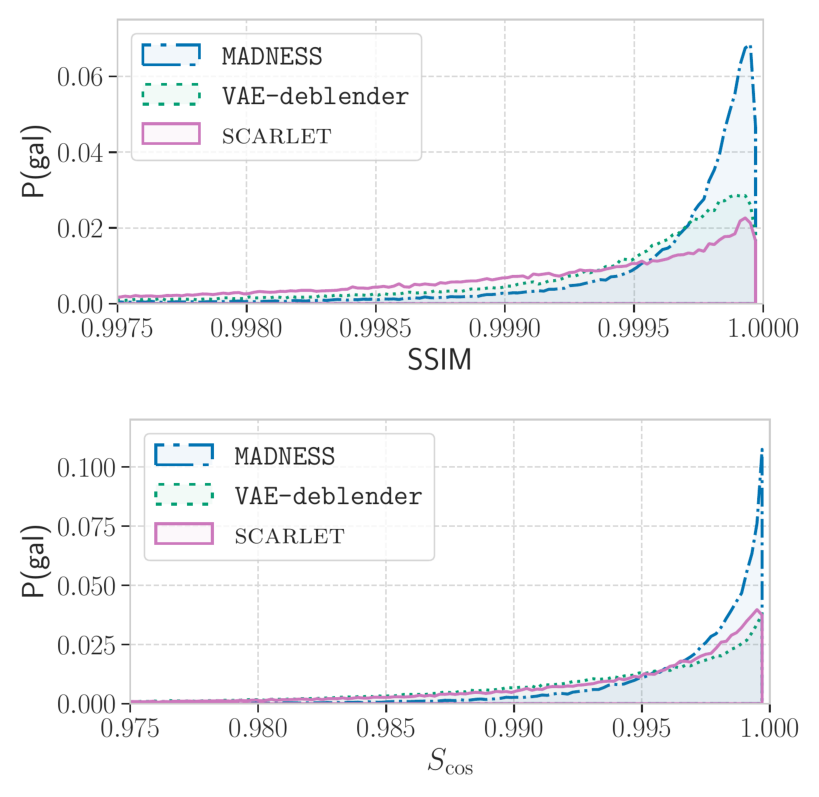

In [ ]:
f, axarr = plt.subplots(2, 1, figsize=(8, 8))


# axarr[0].imshow(mpimg.imread(os.path.join(result_dir_pth, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(
    convert_from_path(
        os.path.join("results", density_level + "_density", "temp", "ssim_res_r.pdf")
    )[0]
)
axarr[1].imshow(
    convert_from_path(
        os.path.join("results", density_level + "_density", "temp", "cosd_res_r.pdf")
    )[0]
)

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
[ax.margins(y=0, x=0) for ax in axarr.ravel()]


plt.tight_layout(pad=0)

plt.savefig(
    os.path.join("results", density_level + "_density", "morphology_results.pdf"),
    format="pdf",
    bbox_inches="tight",
)

plt.show()